# Introduction

## Goals

* Measure the numerical precision of [fmriprep](https://github.com/nipreps/fmriprep)

## Methods

* Processed session `ses-001` of subject `sub-032633` in [SIMON dataset](https://portal.conp.ca/dataset?id=projects/SIMON-dataset)
* fmriprep options:
`--random-seed 1234 --fs-no-reconall --anat-only`
* fmriprep container was patched ([Dockerfile](https://github.com/glatard/fmriprep-1/blob/master/Dockerfile_fuzzy), build on Feb 24) with "fuzzy" libmath introducing random perturbations in the least-significant bit of floating-point numbers (inputs and outputs of functions manipulating floating-point numbers).
* This numerical perturbation is supposed to simulate the effect of OS updates

# Utils

In [1]:
import numpy as np
import nibabel as nib
import os.path as op

from nilearn import plotting as nilp
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
# From https://raw.githubusercontent.com/gkpapers/2020AggregateMCA/master/code/utils.py
def sigdig(array, base=2, axis=-1):
    '''
    Compute significant digits of array elements along axis
    '''
    try:
        # If we have a float, this is our value of epsilon
        eps = np.finfo(array.dtype).eps
    except ValueError:
        # If it's an int, we want to convert it to a float of the same number of
        # bits to get our estimate of epsilon
        a2_dtype = "np.float{0}".format(array.dtype.itemsize*8)
        a2 = array.astype(eval(a2_dtype))
        warnings.warn("Converting array from {} to {}".format(array.dtype,
                                                              a2.dtype),
                      Warning)
        # Re-call the function with the float version
        return sigdig(a2, base=base, axis=axis)

    # Initialize empty matrix the same size of the array
    shp = list(array.shape)
    shp.pop(axis)
    sigs = np.empty(shp)
    sigs[:] = np.NaN

    # Compute the standard deviation and handle special case 1:
    #   - if no variance, maximum significance
    sd = np.std(array, axis=axis)
    c1locs = np.where(sd == 0)
    sigs[c1locs] = -np.log(eps)/np.log(base)

    # Compute the mean and handle special case 2:
    #   - if mean of 0, no significance.
    #   - N.B. this is the incorrect formula for zero-centered data
    mn = np.mean(array, axis=axis)
    c2locs = np.where(mn == 0)
    for c2l in zip(*c2locs):
        if np.isnan(sigs[c2l]):
            sigs[c2l] = 0

    # Otherwise, compute the number of significant digits using Parker, 1997
    c3locs = np.where(np.isnan(sigs))
    for c3l in zip(*c3locs):
        sigs[c3l] = -np.log(np.abs(sd[c3l] / mn[c3l]) + eps)/np.log(base)

    # Reset any negative values to zero
    c4l = np.where(sigs <= 0)
    sigs[c4l] = 0

    # Round up to nearest full bit, and return
    sigs = np.ceil(sigs).astype(int)
    return sigs

def plot_array(array, cmap=mpl.cm.viridis):
    fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(11, 8))
    ni_img = nib.Nifti1Image(array, nib.load(image_files[0]).affine)

    #fig.suptitle("(b) Distributions of significant bits averaged among 20 subjects on MNI space", fontsize=14)
    nilp.plot_img(ni_img, draw_cross=False, cmap=cmap, axes=axes,
                  annotate=False, black_bg=False, colorbar=True)

# Spatial normalization

## Significant digits

Using the functions defined above, we can now compute the number of significant digits in the images normalized to the MNI template.

In [3]:
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
mask_name ="fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
n_samples = 3
condition = 'mca'

In [8]:
# Load brain mask
mask = nib.load(op.join(condition, "0", mask_name))
mask_ = mask.get_fdata().astype('bool')

In [5]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

In [6]:
# Get significant digits
sigdigs = sigdig(array, base=10, axis=0)

In [9]:
# Mean sigdigits
#np.mean(sigdigs, where=mask.get_fdata().astype('bool'))
np.mean(sigdigs[mask_])

2.87099909635977

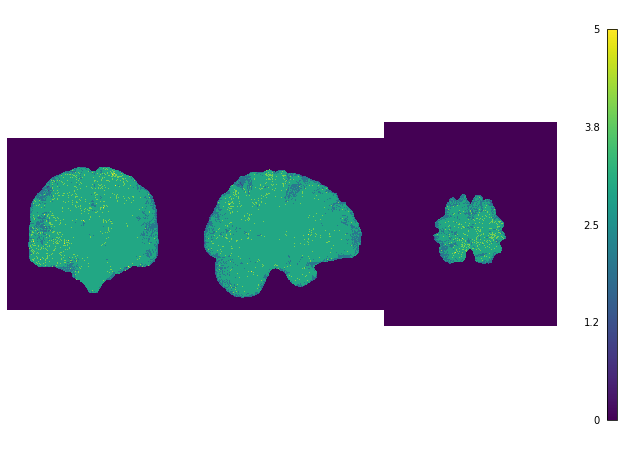

In [12]:
# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs = np.where(mask_data>0, sigdigs, mask_data)
plot_array(masked_sigdigs)

The average number of significant digits is 3.1 on a scale of 16.

## Visual differences

Apply brain mask of sample 0 to spatially-normalized samples:

In [14]:
%%bash
for sample in 0 1 2
do
    FSLOUTPUTTYPE=NIFTI_GZ\
    fslmaths mca/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz -mul\
             mca/${sample}/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz\
             ${sample}.nii.gz
done

In [15]:
# TAKE SCREENSHOT WITH FSL EYES :)

In [16]:
%%bash
convert -loop 0 0.png 1.png 2.png spatial-norm.gif

<img src="./spatial-norm.gif"/>

# Tissue class probabilities

## White matter

In [17]:
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_label-WM_probseg.nii.gz"

Mean sigdigits: 5.1411363954146


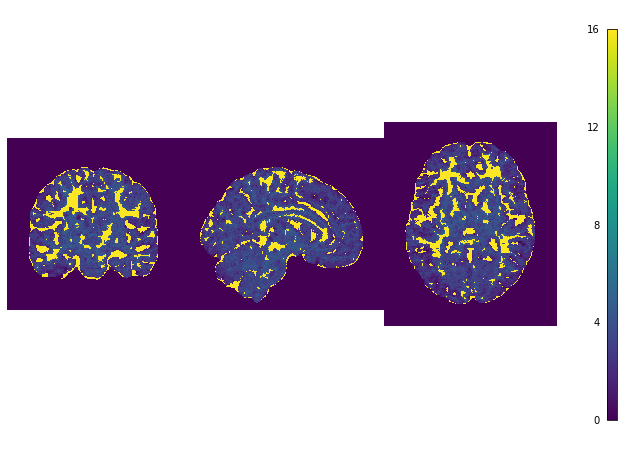

In [19]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

# Get significant digits
sigdigs = sigdig(array, base=10, axis=0)

# Mean sigdigits
#print("Mean sigdigits:", np.mean(sigdigs, where=mask.get_fdata().astype('bool')))
print("Mean sigdigits:", np.mean(sigdigs[mask_]))

# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs = np.where(mask_data>0, sigdigs, mask_data)
plot_array(masked_sigdigs)

In [21]:
%%bash
for sample in 0 1 2
do
    FSLOUTPUTTYPE=NIFTI_GZ\
    fslmaths mca/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz -mul\
             mca/${sample}/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_label-WM_probseg.nii.gz\
             ${sample}-WM.nii.gz
done

In [15]:
# TAKE SCREENSHOT WITH FSL EYES :)

In [22]:
%%bash
convert -loop 0 0-wm.png 1-wm.png 2-wm.png wm.gif

<img src="./wm.gif"/>

## Gray matter

In [23]:
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz"

Mean sigdigits: 4.122378034655542


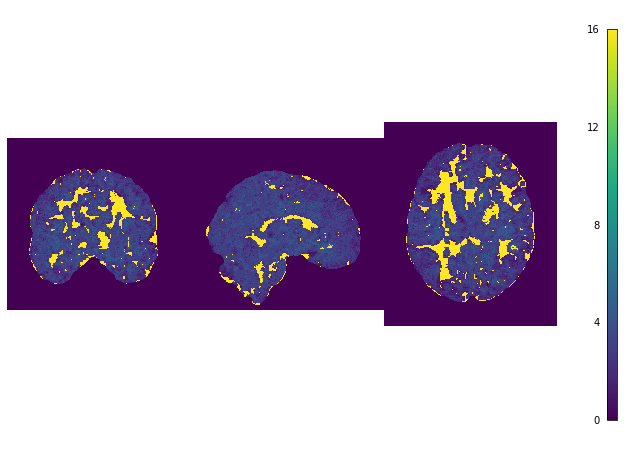

In [24]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

# Get significant digits
sigdigs = sigdig(array, base=10, axis=0)

# Mean sigdigits
#print("Mean sigdigits:", np.mean(sigdigs, where=mask.get_fdata().astype('bool')))
print("Mean sigdigits:", np.mean(sigdigs[mask_]))

# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs = np.where(mask_data>0, sigdigs, mask_data)
plot_array(masked_sigdigs)

In [25]:
%%bash
for sample in 0 1 2
do
    FSLOUTPUTTYPE=NIFTI_GZ\
    fslmaths mca/0/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz -mul\
             mca/${sample}/fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz\
             ${sample}-GM.nii.gz
done

In [26]:
# TAKE SCREENSHOT WITH FSL EYES :)

In [27]:
%%bash
convert -loop 0 0-gm.png 1-gm.png 2-gm.png gm.gif

<img src="./gm.gif"/>

# IEEE (non-perturbed) samples

Let's check that significant digits are maximal for IEEE samples. We changed the following parameters in data processing:
* fmriprep: same as before (including `--random-seed 1234`
* verificarlo: `VFC_BACKENDS='libinterflop_ieee.so'`

## Resampled images

In [22]:
condition = 'ieee'
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
n_samples = 2

In [23]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

In [24]:
# Get significant digits
sigdigs = sigdig(array, base=10, axis=0)

In [25]:
# Mean sigdigits
np.mean(sigdigs, where=mask.get_fdata().astype('bool'))

3.265041558993109

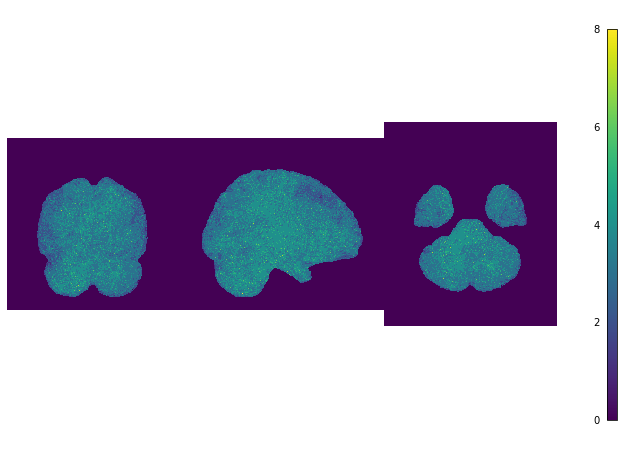

In [26]:
# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs = np.where(mask_data>0, sigdigs, mask_data)
plot_array(masked_sigdigs)

oops... Let's check what happened, we're supposed to have identical results in this case. Maybe an issue with how the random seed is set?

# Random seeds

Let's compare the variability obtained with numerical perturbations to the one resulting from using different random seeds (wip).

## Resampled images

In [32]:
condition = 'seed'
file_name = "fmriprep/sub-032633/ses-001/anat/sub-032633_ses-001_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
n_samples = 3

In [33]:
# Build array of samples
image_files = [op.join(condition, str(i), file_name) for i in range(n_samples)]
array = np.array([(nib.load(image_file).get_fdata()) for image_file in image_files])

In [34]:
# Get significant digits
sigdigs = sigdig(array, base=10, axis=0)

In [35]:
# Mean sigdigits
np.mean(sigdigs, where=mask.get_fdata().astype('bool'))

2.9863664798325016

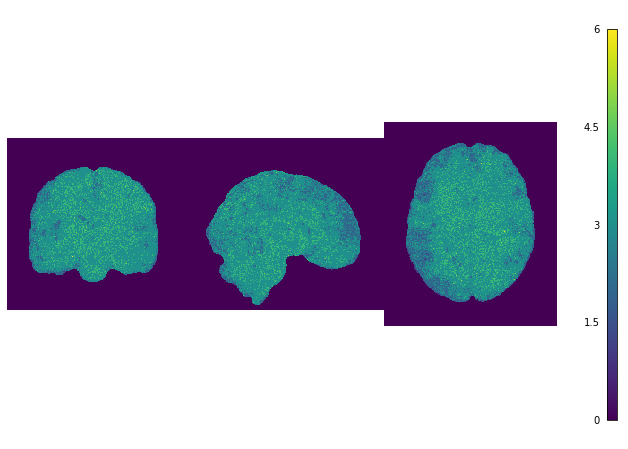

In [36]:
# Plot masked sigdigits
mask_data = mask.get_fdata()
masked_sigdigs = np.where(mask_data>0, sigdigs, mask_data)
plot_array(masked_sigdigs)

In [ ]:
# Next steps

* Investigate why `--random-seed` doesn't seem to lead to deterministic results 
* Make more samples per dataset
* Add more sessions / subjects
* Extend to functional pipeline
* Conclude on acceptab